In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import os
import cv2
from PIL import Image
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-12-24 20:38:54.926306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 20:38:54.926334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 20:38:54.927135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 20:38:54.932534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 20:38:55.821524: W tensorflow/compiler/tf2

##### Verstappen vs Leclerc

Verstappen images list

In [2]:
class preprocess:
    def __init__(self, path):
        self.path = path
        self.dir_list = os.listdir(path)
        self.img = np.empty((1,0))
        self.label = np.empty((1,0))
        self.target_size=None

        self.x_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        print(f"dir_list: {self.dir_list}")

    def show_shape(self):
        print(f"x_train shape: {self.x_train.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def load_data(self, targetsize):
        self.target_size =  targetsize

        for dir in self.dir_list:
            for img in os.listdir(self.path+'/'+dir):
                name = (re.findall('[a-z]+', img)[0])
                num = int(re.findall('\d+', img)[0])
                #print(self.path+'/'+dir+'/'+img)

                img_to_convert = Image.open(self.path+'/'+dir+'/'+img)
                img_array = np.array(img_to_convert)
                img_array = img_array[:,:,:3]
                # print(img_array)
                img_array_resized = cv2.resize(img_array, self.target_size)

                if 1 <= num <= 30:
                    self.x_train.append(img_array_resized)
                    if name == "leclerc":
                        self.y_train.append(0)
                    elif name == 'ver':
                        self.y_train.append(1)
                        
                elif 31 <= num <= 41:
                    self.x_test.append(img_array_resized)
                    if name == "leclerc":
                        self.y_test.append(0)
                    elif name == "ver":
                        self.y_test.append(1)
                        
        self.y_train = tf.keras.utils.to_categorical(self.y_train, 2)
        self.y_test = tf.keras.utils.to_categorical(self.y_test, 2)
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)        

In [3]:
datasets = preprocess("/home/yms/ws/mldl/data/f1driver")

dir_list: ['leclerc', 'verstappen']


In [4]:
datasets.load_data((128, 128))

In [5]:
datasets.x_train[1]

array([[[  2,   6,  10],
        [  2,   6,  10],
        [  2,   6,  10],
        ...,
        [ 54,  52,  49],
        [ 53,  51,  48],
        [ 52,  50,  47]],

       [[  5,  12,  22],
        [  5,  12,  22],
        [  5,  12,  22],
        ...,
        [114, 109, 102],
        [113, 107, 101],
        [110, 105,  99]],

       [[  5,  12,  22],
        [  5,  12,  22],
        [  5,  12,  22],
        ...,
        [109, 104,  98],
        [107, 103,  96],
        [105, 100,  93]],

       ...,

       [[167,   3,  21],
        [206,   2,  35],
        [240,   0,  48],
        ...,
        [208,   2,  13],
        [208,   1,  13],
        [226,   1,  19]],

       [[182,   7,  23],
        [211,   5,  32],
        [240,   2,  44],
        ...,
        [208,   1,  13],
        [212,   0,  14],
        [230,   1,  21]],

       [[201,   5,  29],
        [222,   2,  34],
        [239,   5,  42],
        ...,
        [205,   0,   8],
        [222,   2,  12],
        [233,   3,  15]]

In [6]:
datasets.show_shape()

x_train shape: (60, 128, 128, 3)
x_test shape: (22, 128, 128, 3)
y_train shape: (60, 2)
y_test shape: (22, 2)


In [7]:
class CNN_Model:
    def __init__(self, batch_size, epochs, input_shape, optimizer, loss):
        self.model = Sequential()
        self.kernal = (3,3)
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.loss = loss
        self.hist = None
        self.res = None

    def First_layer(self,filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation, input_shape=self.input_shape))

    def Conv(self, filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation))

    def Pool(self, pool_size):
        self.model.add(MaxPooling2D(pool_size=pool_size))

    def Dense(self, filters, activation):
        self.model.add(Dense(filters, activation=activation))
        
    def Flatten(self):
        self.model.add(Flatten())

    def Dropout(self, ratio):
        self.model.add(Dropout(ratio))

    def compile(self):
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

    def fit(self, x_train, y_train, x_test, y_test, patience):
        timestamp = int(time.time())
        checkpoint=ModelCheckpoint(filepath=f'best_model_weights_{timestamp}.h5', save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)
        early_stopping = EarlyStopping( monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
        self.hist = self.model.fit(x_train, y_train, batch_size=self.batch_size, epochs=self.epochs, callbacks=[checkpoint, early_stopping], validation_data=(x_test, y_test), verbose=2)
    
    def evaluate(self, x_test, y_test):
        self.res = self.model.evaluate(x_test, y_test, verbose=0)
        print(f"acc of this model: {self.res[1]*100:.2f}%")
    

In [8]:
mymodel = CNN_Model(128, 90, datasets.x_train[0].shape, Adam(), 'categorical_crossentropy')

mymodel.First_layer(8, (3,3), 'relu')
mymodel.Conv(32, (3,3), 'relu')
mymodel.Conv(32, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Dropout(0.25)
mymodel.Conv(256, (3,3), 'relu')
mymodel.Conv(512, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Flatten()
mymodel.Dense(128, 'relu')
mymodel.Dropout(0.5)
mymodel.Dense(2, 'softmax')

2024-12-24 20:39:06.602446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-24 20:39:06.637339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-24 20:39:06.637640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
mymodel.compile()

In [16]:
mymodel.fit(datasets.x_train, datasets.y_train, datasets.x_test, datasets.y_test, 20)

Epoch 1/90

Epoch 1: val_loss improved from inf to 0.64753, saving model to best_model_weights_1735040611.h5
1/1 - 1s - loss: 0.5516 - accuracy: 0.7167 - val_loss: 0.6475 - val_accuracy: 0.7273 - 952ms/epoch - 952ms/step
Epoch 2/90

Epoch 2: val_loss did not improve from 0.64753
1/1 - 0s - loss: 0.4355 - accuracy: 0.8500 - val_loss: 0.7369 - val_accuracy: 0.6818 - 268ms/epoch - 268ms/step
Epoch 3/90

Epoch 3: val_loss did not improve from 0.64753
1/1 - 0s - loss: 0.3054 - accuracy: 0.9000 - val_loss: 0.7822 - val_accuracy: 0.6818 - 272ms/epoch - 272ms/step
Epoch 4/90

Epoch 4: val_loss did not improve from 0.64753
1/1 - 0s - loss: 0.2914 - accuracy: 0.9167 - val_loss: 0.7932 - val_accuracy: 0.7273 - 269ms/epoch - 269ms/step
Epoch 5/90

Epoch 5: val_loss did not improve from 0.64753
1/1 - 0s - loss: 0.1749 - accuracy: 0.9500 - val_loss: 0.7779 - val_accuracy: 0.7273 - 271ms/epoch - 271ms/step
Epoch 6/90

Epoch 6: val_loss did not improve from 0.64753
1/1 - 0s - loss: 0.2631 - accuracy: 

In [17]:
mymodel.evaluate(datasets.x_test, datasets.y_test)

acc of this model: 72.73%


save weights

In [20]:
mymodel.model.load_weights("/home/yms/ws/git_ws/LearningModel/MyNote/CNN_Model/best_model_weights_1735040611.h5")

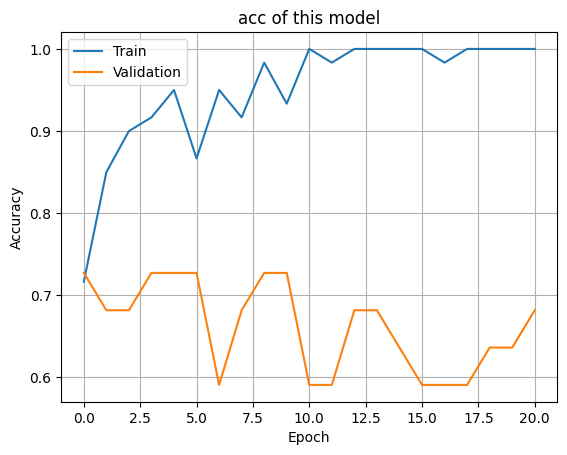

In [18]:
plt.plot(mymodel.hist.history['accuracy'])
plt.plot(mymodel.hist.history['val_accuracy'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("acc of this model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

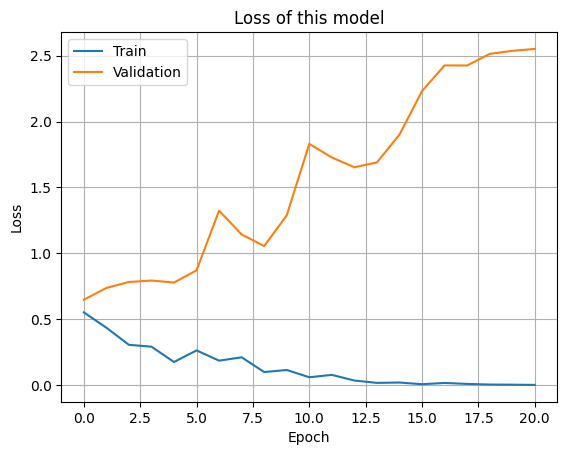

In [19]:
plt.plot(mymodel.hist.history['loss'])
plt.plot(mymodel.hist.history['val_loss'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("Loss of this model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [28]:
def img_into_numpy(path):
    test_list = []
    img_list = os.listdir(path)
    for imgs in img_list:
        img = Image.open(path+'/'+imgs)
        img_array = np.array(img)
        img_array = img_array[:,:,:3]

        img_array = cv2.resize(img_array, (128,128))
        test_list.append(img_array)

    test_list = np.array(test_list)
    print(f"shape of test_data: {test_list.shape}")

    return test_list


In [39]:
test_data = img_into_numpy("****")

shape of test_data: (4, 128, 128, 3)


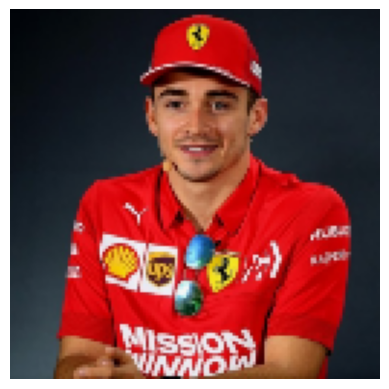

1/1 [==============================] - 0s 18ms/step
Predicted class: 0
It's Charles Leclerc!


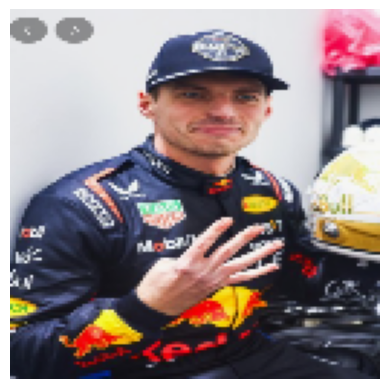

1/1 [==============================] - 0s 29ms/step
Predicted class: 1
It's Max Verstappen!


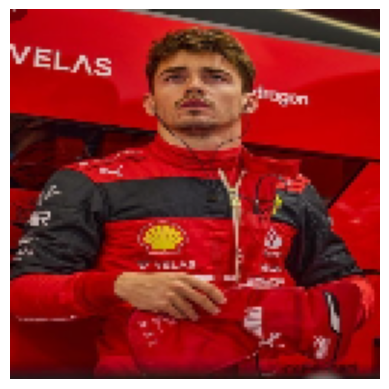

1/1 [==============================] - 0s 18ms/step
Predicted class: 0
It's Charles Leclerc!


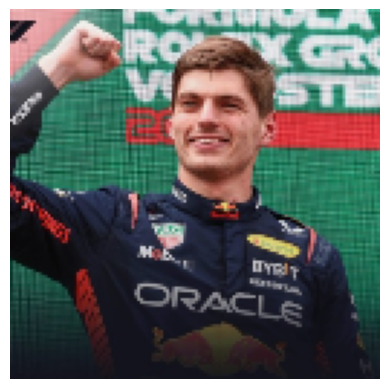

1/1 [==============================] - 0s 39ms/step
Predicted class: 1
It's Max Verstappen!


In [40]:
for each_data in test_data:
    plt.imshow(each_data)
    plt.axis("off")
    plt.show()
    
    # augment array_size (batch_size).
    each_data = np.expand_dims(each_data, axis=0)
    prediction = mymodel.model.predict(each_data)
    print("Predicted class:", prediction[0].argmax())
    if prediction[0].argmax() == 0:
        print("It's Charles Leclerc!")
    elif prediction[0].argmax() == 1:
        print("It's Max Verstappen!")


When you get an error like 'GPU EXHAUSTED'

In [22]:
from numba import cuda

device = cuda.get_current_device()
device.reset()